# How to Train YOLOv9 on a Custom Dataset
---
Adapted code from:
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/XHT2c8jT3Bc)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Thu Jul  4 10:30:45 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:65:00.0  On |                  N/A |
| 31%   42C    P8    35W / 350W |    704MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/llama/Enrique/maderas


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [6]:
#!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

/home/llama/Enrique/env_enrique/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


[Errno 2] No such file or directory: 'yolov9'
/home/llama/Enrique/maderas/yolov9


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [ ]:
!pip install -q roboflow

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.7 requires opencv-python-headless>=4.9.0, but you have opencv-python-headless 4.8.0.74 which is incompatible.


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e-converted.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-m-converted.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c-det.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c-seg.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c-seg.pt

In [3]:
!ls -la {HOME}/weights

total 775588
drwxrwxr-x 2 llama llama      4096 jul  3 17:50 .
drwxrwxr-x 7 llama llama      4096 jul  3 18:16 ..
-rw-rw-r-- 1 llama llama  51508645 mar 17 01:20 gelan-c-det.pt
-rw-rw-r-- 1 llama llama  51508261 feb 18 13:36 gelan-c.pt
-rw-rw-r-- 1 llama llama  55807471 mar 17 01:20 gelan-c-seg.pt
-rw-rw-r-- 1 llama llama 117203713 feb 18 13:36 gelan-e.pt
-rw-rw-r-- 1 llama llama 103153312 feb 18 13:36 yolov9-c.pt
-rw-rw-r-- 1 llama llama 116904429 mar 23 02:24 yolov9-c-seg.pt
-rw-rw-r-- 1 llama llama 117160386 feb 27 01:43 yolov9-e-converted.pt
-rw-rw-r-- 1 llama llama 140217688 feb 18 13:36 yolov9-e.pt
-rw-rw-r-- 1 llama llama  40675619 jun  1 14:20 yolov9-m-converted.pt


## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [3]:
%cd {HOME}/yolov9

/home/llama/Enrique/maderas/yolov9


/home/llama/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [4]:
#!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="uNR0NzT4q3UFPn3QgHEL")
project = rf.workspace("tfm-bhabc").project("wood-annotation")
version = project.version(9)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...


## Train Custom Model

### Gelan-C

In [11]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 200 --img 512 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/home/llama/Enrique/maderas/yolov9
train: weights=/home/llama/Enrique/maderas/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/data.yaml, hyp=hyp.scratch-high.yaml, epochs=200, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=15, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_moment

### GELAN-C-SEG

In [24]:
%cd {HOME}/yolov9
!python segment/train.py --workers 8 --device 0 --batch 16  --data {dataset.location}/data.yaml --img 640 --cfg models/segment/gelan-c-seg.yaml --weights {HOME}/weights/gelan-c-seg.pt --name gelan-c-seg --hyp hyp.scratch-high.yaml --no-overlap --epochs 300 --close-mosaic 10

/home/llama/Enrique/maderas/yolov9
segment/train: weights=/home/llama/Enrique/maderas/weights/gelan-c-seg.pt, cfg=models/segment/gelan-c-seg.yaml, data=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/data.yaml, hyp=hyp.scratch-high.yaml, epochs=300, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=gelan-c-seg, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, close_mosaic=10, mask_ratio=4, no_overlap=True
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, cls_pw=1.0, obj=0.

### YOLOv9-E

In [37]:
%cd {HOME}/yolov9

!python train_dual.py \
--batch 16 --epochs 150 --img 512 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/yolov9-e.pt \
--cfg models/detect/yolov9-e.yaml \
--hyp hyp.scratch-high.yaml \
--name yolov9-e

/home/llama/Enrique/maderas/yolov9
train_dual: weights=/home/llama/Enrique/maderas/weights/yolov9-e.pt, cfg=models/detect/yolov9-e.yaml, data=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/data.yaml, hyp=hyp.scratch-high.yaml, epochs=150, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov9-e, exist_ok=False, quad=False, cos_lr=False, flat_cos_lr=False, fixed_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, min_items=0, close_mosaic=15, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, w

In [21]:
!python segment/train_dual.py --workers 8 --device 0 --batch 16  --data {dataset.location}/data.yaml --img 512 --cfg models/segment/yolov9-c-dseg.yaml --weights {HOME}/weights/yolov9-c-seg.pt --name yolov9-c-seg --hyp hyp.scratch-high.yaml --no-overlap --epochs 300 --close-mosaic 10

segment/train_dual: weights=/home/llama/Enrique/maderas/weights/yolov9-c-seg.pt, cfg=models/segment/yolov9-c-dseg.yaml, data=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/data.yaml, hyp=hyp.scratch-high.yaml, epochs=300, batch_size=16, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train-seg, name=yolov9-c-seg, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, close_mosaic=10, mask_ratio=4, no_overlap=True
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=7.5, cls=0.5, cls_pw=1.0, obj=0.7, obj_pw=1.0, dfl=1.5, io

IOStream.flush timed out


Transferred 1820/1832 items from /home/llama/Enrique/maderas/weights/yolov9-c-seg.pt
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 298 weight(decay=0.0), 321 weight(decay=0.0005), 319 bias
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
train: Scanning /home/llama/Enrique/maderas/yolov9/Wood-annotation-9/train/label
val: Scanning /home/llama/Enrique/maderas/yolov9/Wood-annotation-9/valid/labels.
Plotting labels to runs/train-seg/yolov9-c-seg15/labels.jpg... 
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/train-seg/yolov9-c-seg15
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
  0%|       

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [12]:
!ls {HOME}/yolov9/runs/train/exp4

confusion_matrix.png				 labels.jpg    results.csv
events.out.tfevents.1720043957.hefesto.169610.0  opt.yaml      results.png
F1_curve.png					 P_curve.png   weights
hyp.yaml					 PR_curve.png
labels_correlogram.jpg				 R_curve.png


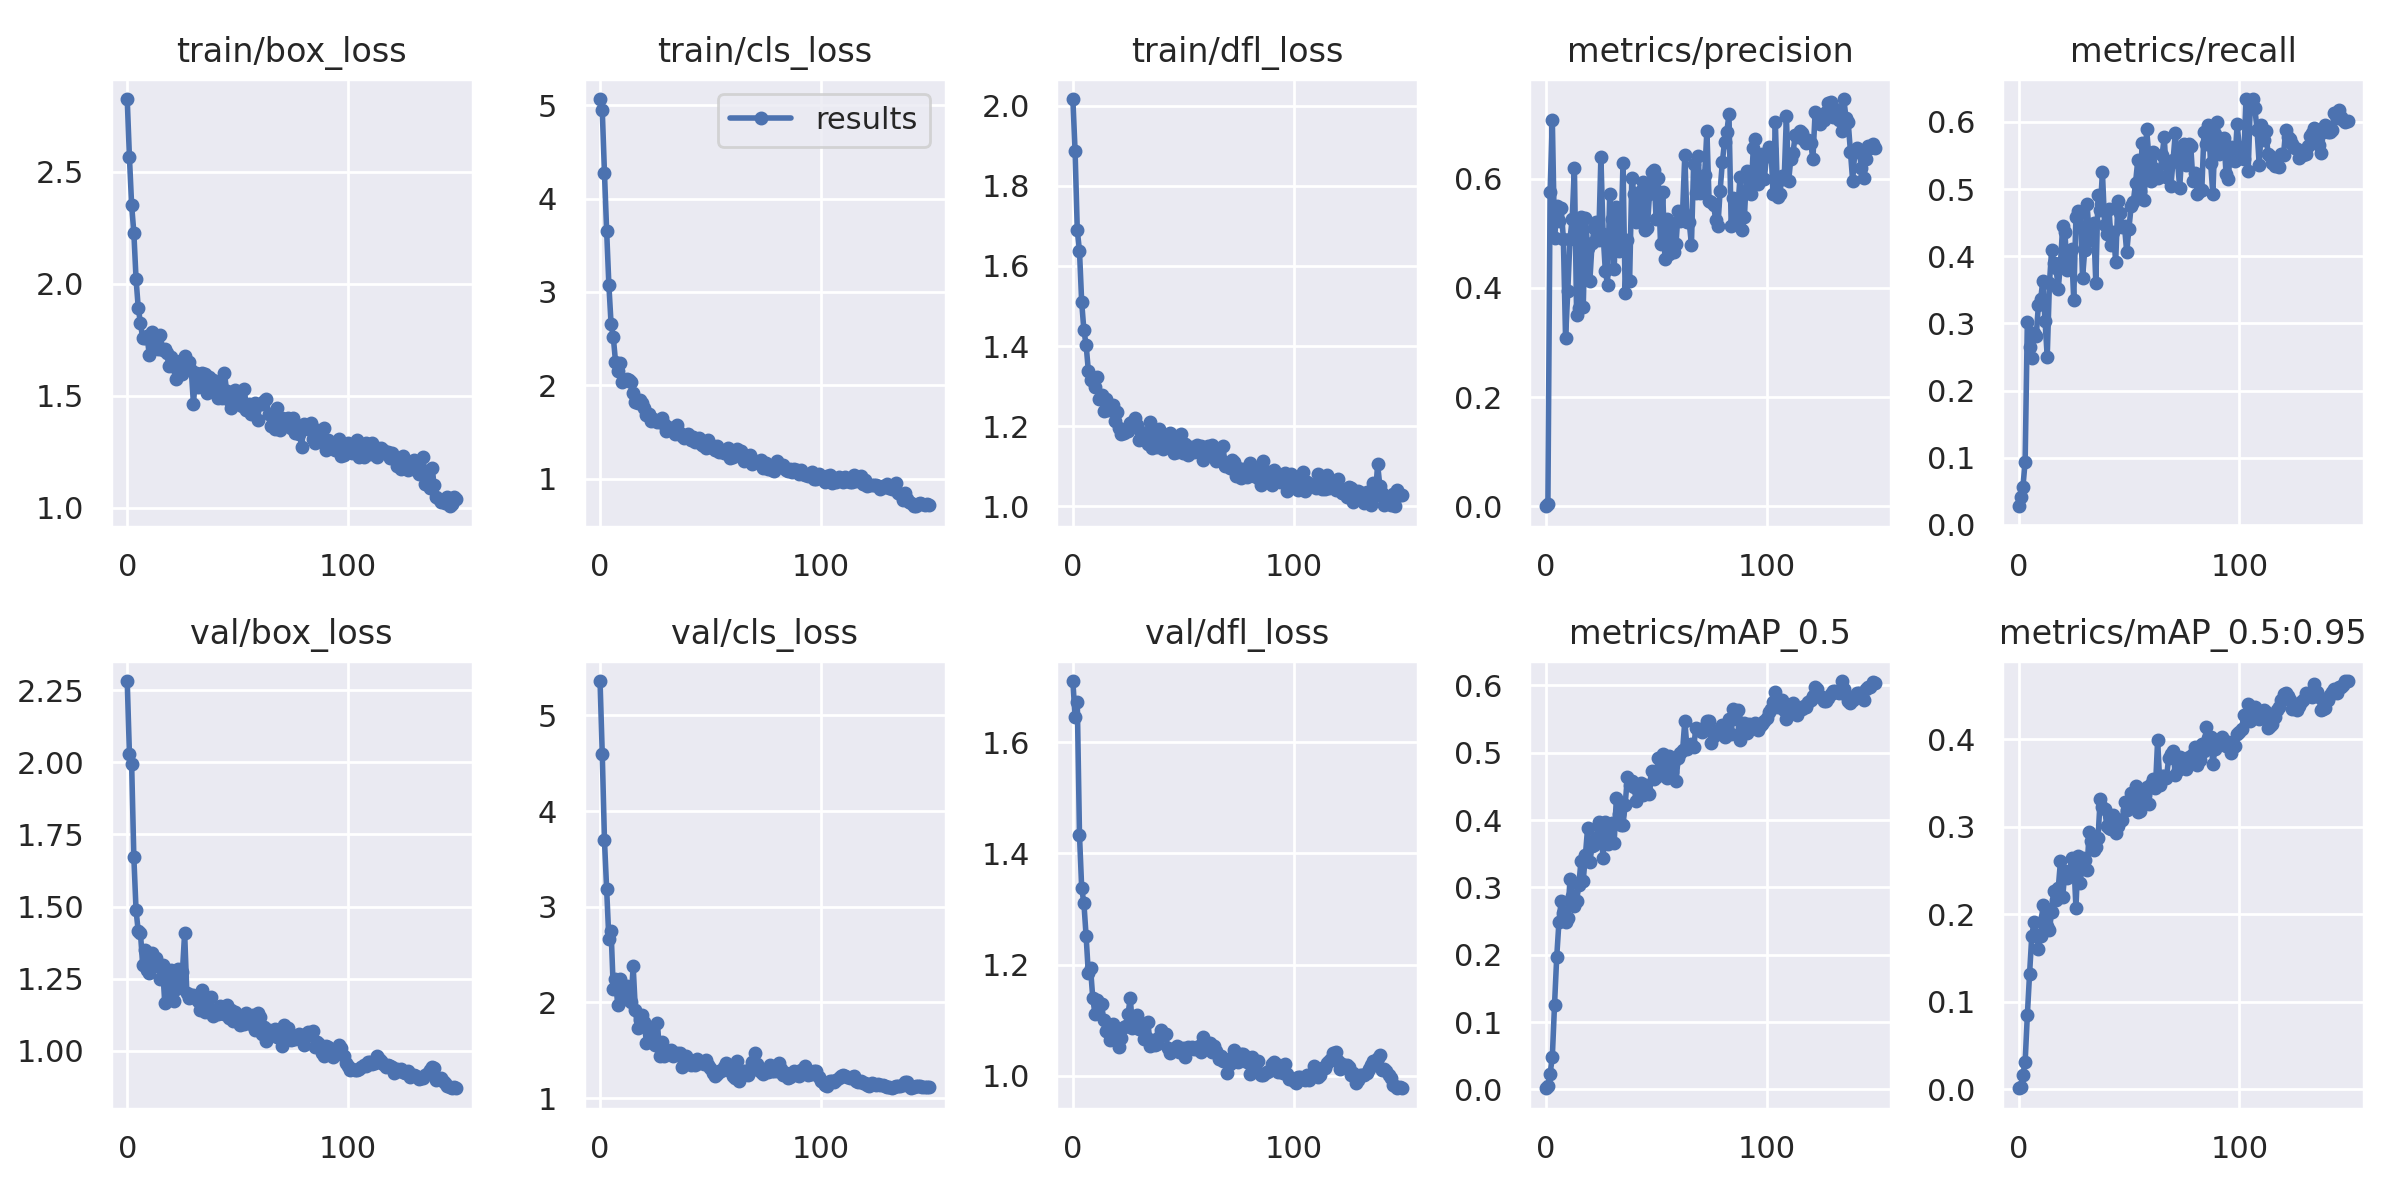

In [17]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp3/results.png", width=1000)

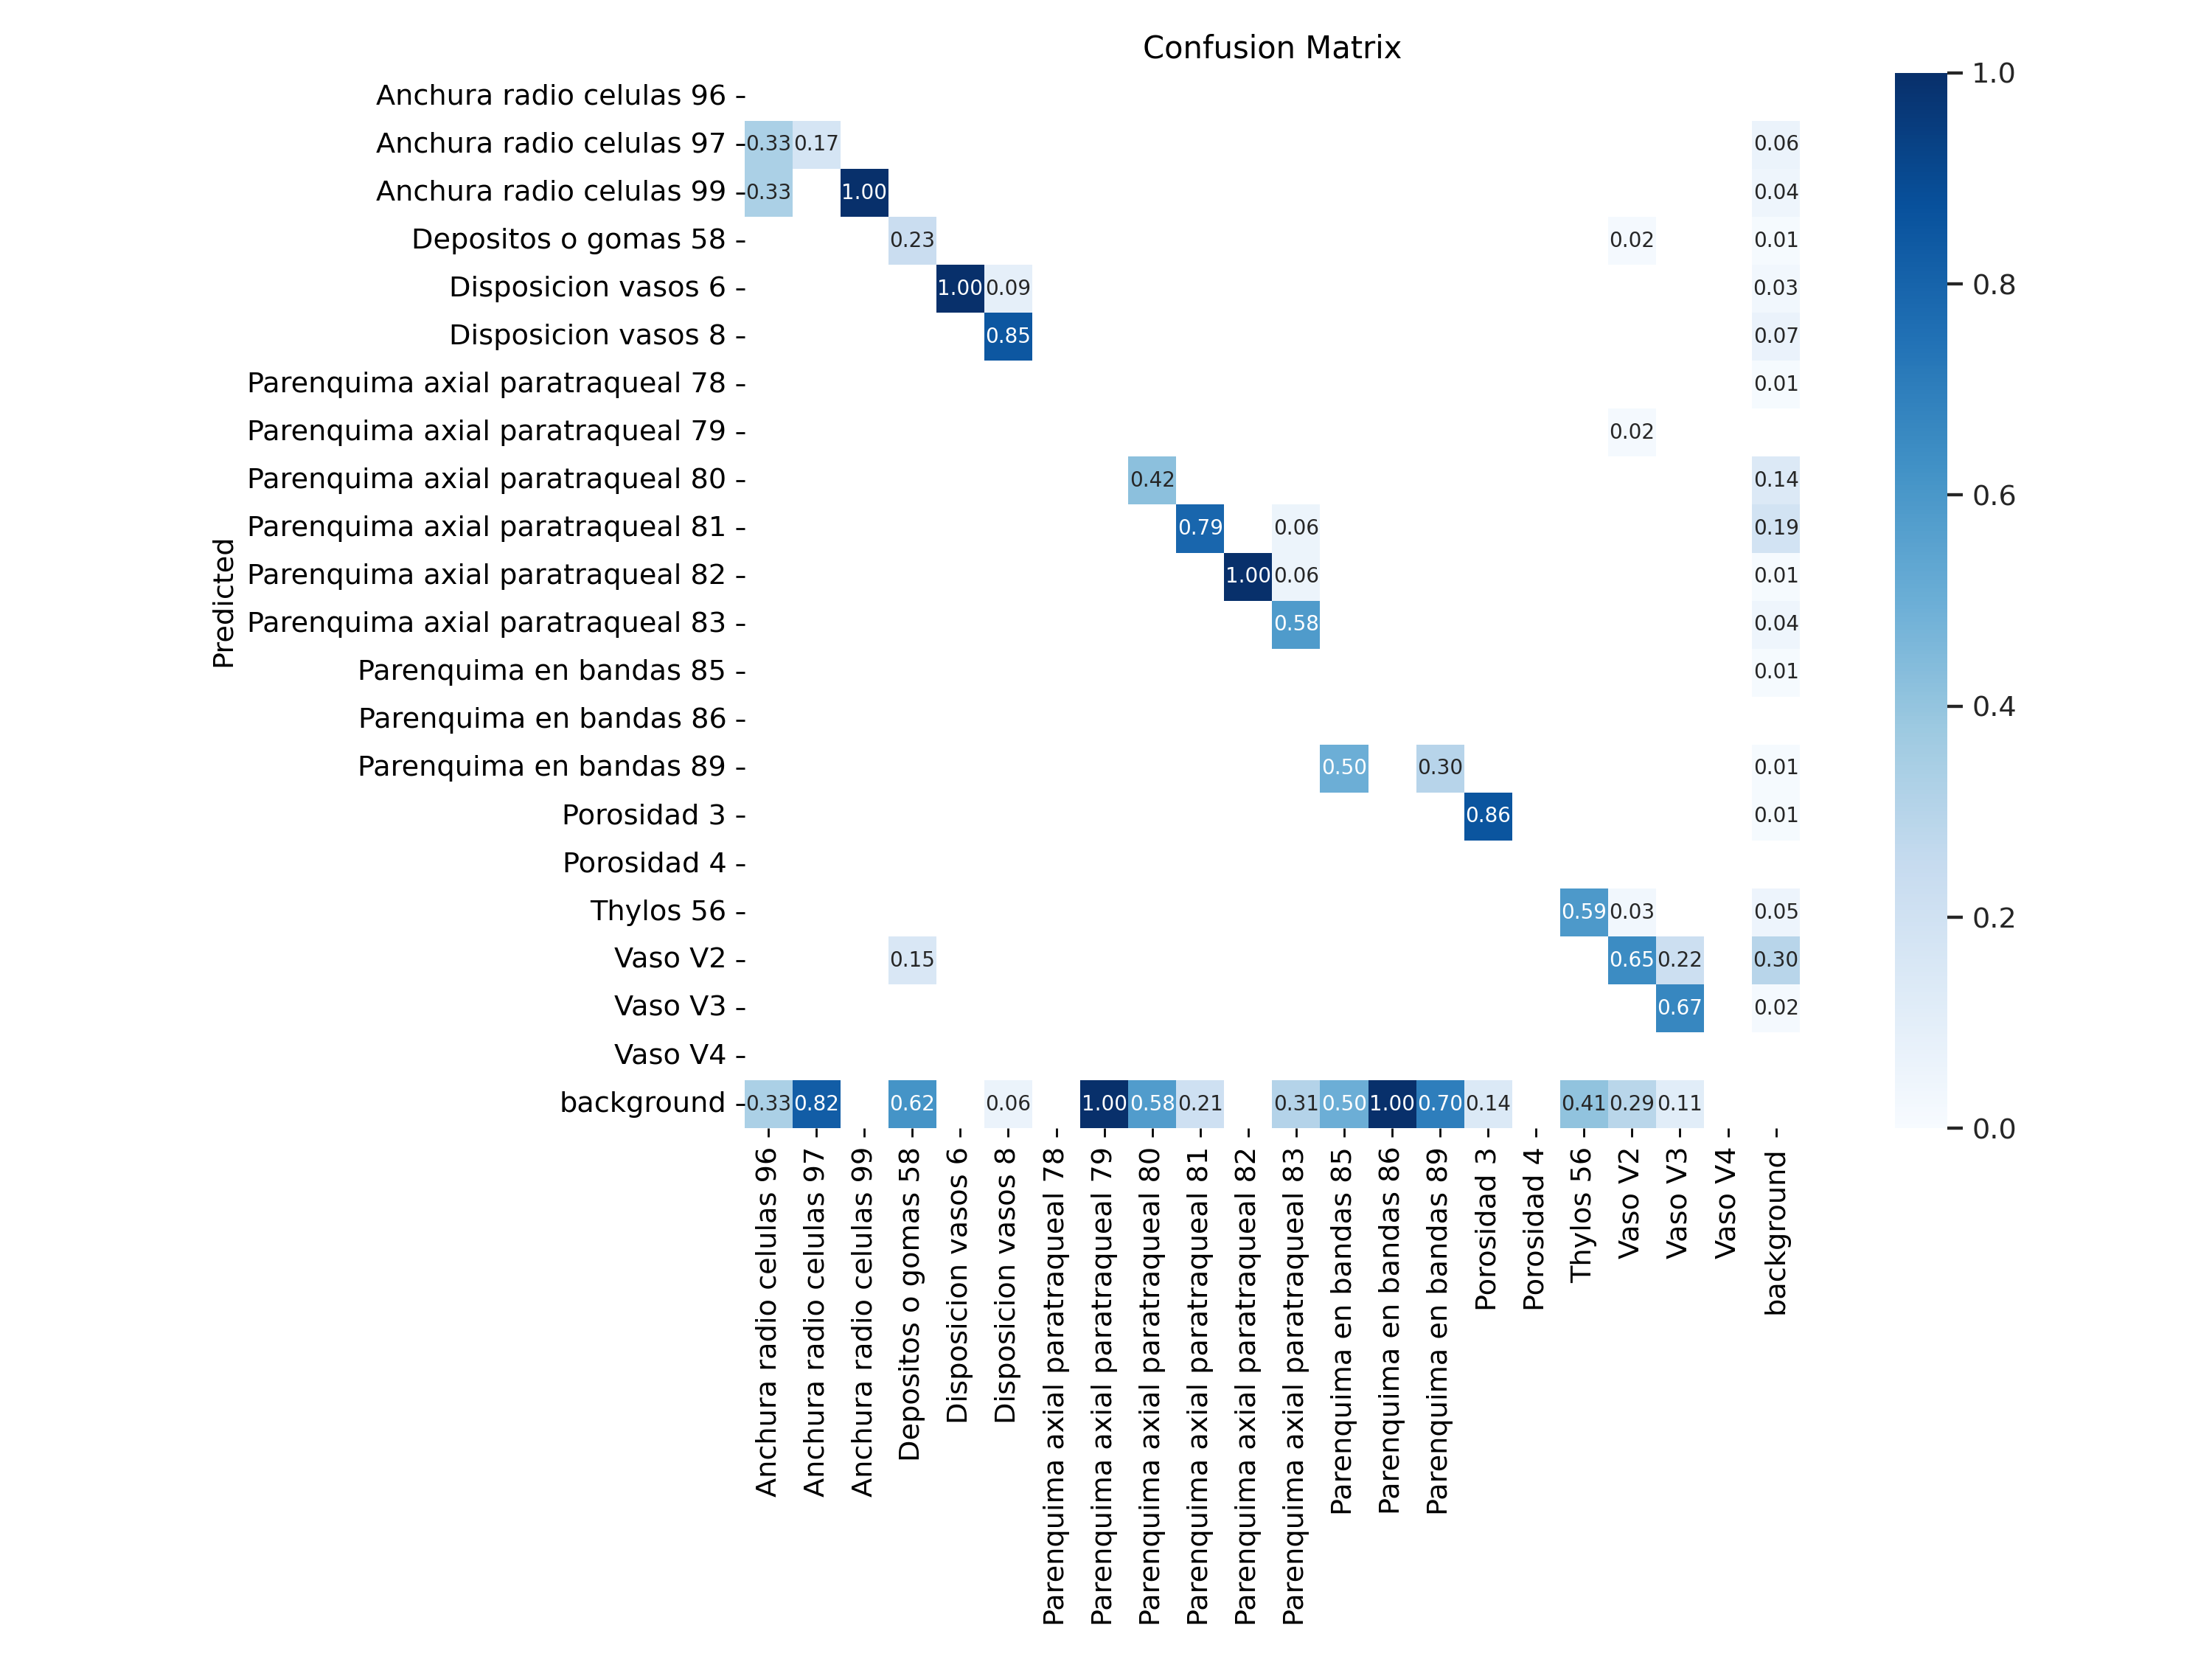

In [15]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp4/confusion_matrix.png", width=1000)

## Validate Custom Model

In [16]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp3/weights/best.pt

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


/home/llama/Enrique/maderas/yolov9
val: data=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/data.yaml, weights=['/home/llama/Enrique/maderas/yolov9/runs/train/exp3/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25243279 parameters, 0 gradients, 101.9 GFLOPs
val: Scanning /home/llama/Enrique/maderas/yolov9/Wood-annotation-9/valid/labels.
                 Class     Images  Instances          P          R      mAP50   
Exception in thread Thread-3 (plot_images):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
  

In [32]:
%cd {HOME}/yolov9

!python val_dual.py \
--img 640 --batch 32 --conf 0.001 --iou 0.6 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/yolov9-e8/weights/best.pt

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.


/home/llama/Enrique/maderas/yolov9
val_dual: data=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/data.yaml, weights=['/home/llama/Enrique/maderas/yolov9/runs/train/yolov9-e8/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

Fusing layers... 
yolov9-e summary: 839 layers, 68578654 parameters, 0 gradients, 240.9 GFLOPs
val: Scanning /home/llama/Enrique/maderas/yolov9/Wood-annotation-9/valid/labels.
                 Class     Images  Instances          P          R      mAP50   
Exception in thread Thread-3 (plot_images):
Traceback (most recent call last):
                   all         12        394      0.724      0.47

## Inference with Custom Model

In [21]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp3/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/home/llama/Enrique/maderas/yolov9/runs/train/exp3/weights/best.pt'], source=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLO 🚀 v0.1-104-g5b1ea9a Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)

Fusing layers... 
gelan-c summary: 387 layers, 25243279 parameters, 0 gradients, 101.9 GFLOPs
image 1/6 /home/llama/Enrique/maderas/yolov9/Wood-annotation-9/test/images/0030-1_jpg.rf.9d6568d8c612da31b2472577cea99103.jpg: 1280x1280 4 Anchura radio celulas 97s, 1 Parenquima axial paratraqueal 78, 20 Parenquima axial paratraqueal 80s, 18 Pare

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

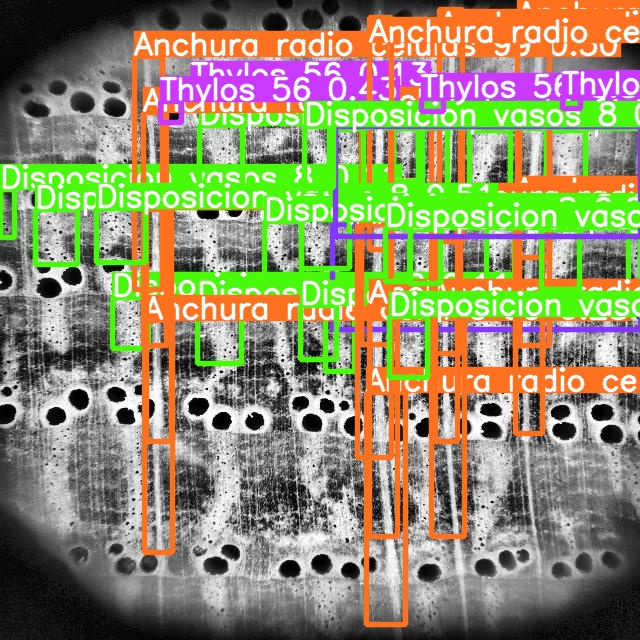

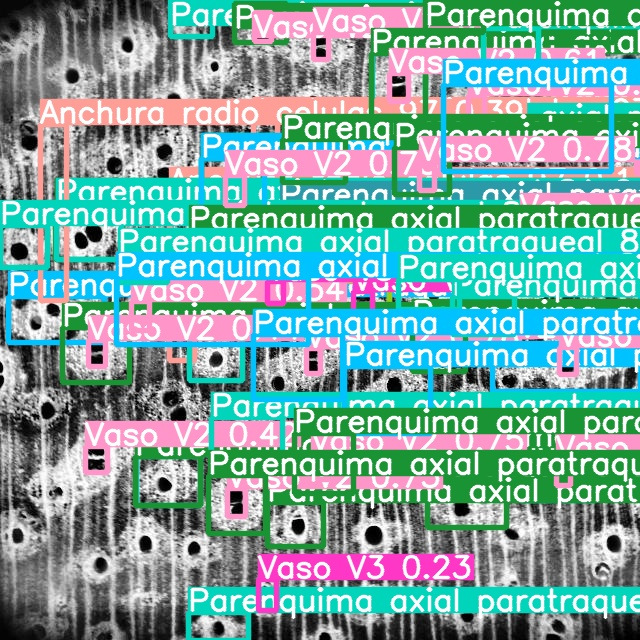

In [25]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp9/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

In [22]:
!python segment/predict.py \
--conf 0.1 --device 0 --max-det 1000\
--weights {HOME}/yolov9/runs/train-seg/gelan-c-seg3/weights/best.pt \
--source {dataset.location}/test/images/

segment/predict: weights=['/home/llama/Enrique/maderas/yolov9/runs/train-seg/gelan-c-seg3/weights/best.pt'], source=/home/llama/Enrique/maderas/yolov9/Wood-annotation-9/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
requirements: YOLO requirement "albumentations>=1.0.3" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.1.29 requires opencv-python-headless==4.8.0.74, but you have opencv-python-headless 4.10.0.84 which is incompatible.

[n

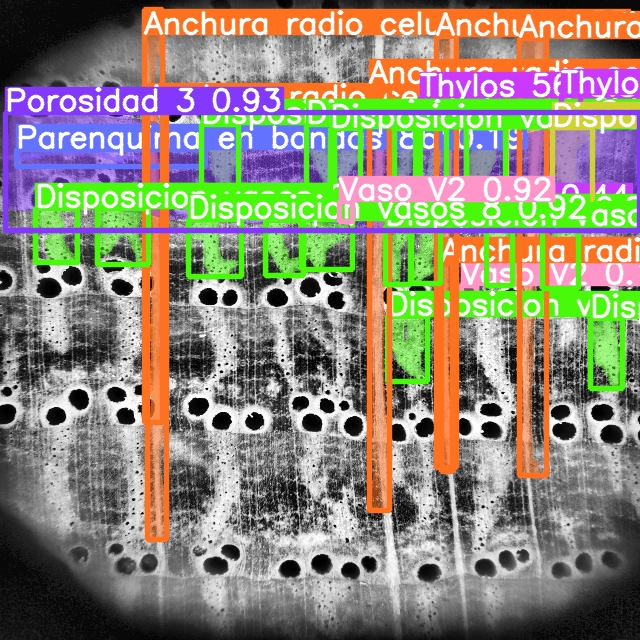

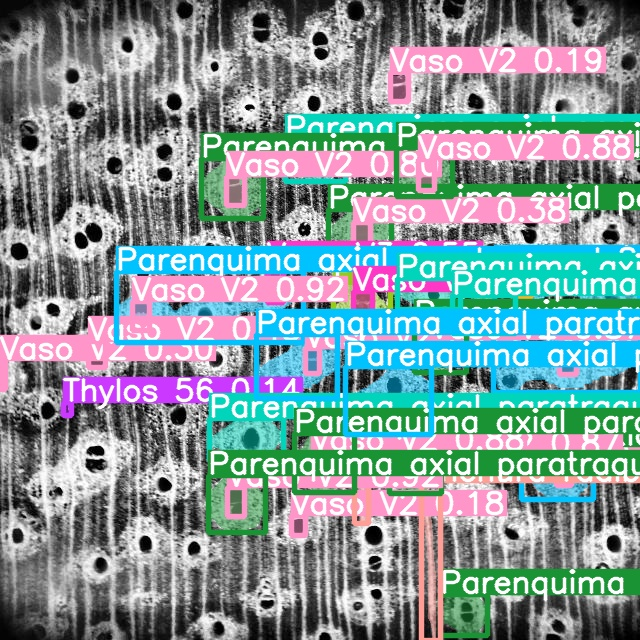

In [26]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/predict-seg/exp10/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))